# Project 1: Image Classification

## Task 0: Getting Started

Read the getting started guide titled **"Python for Deep Learning"** and get familiar with Python and PyTorch. Read the provided code below and get familiar with the commands and their parameters to understand what the code is trying to do. We recommend to spend a fair amount of time to understand all the different parts of the code. This understanding will be important for this and future projects.

The goal of this project is to implement the *“Hello World!”* program of deep learning: designing and training a network that performs image classification. The dataset we will be using is CIFAR10 which is a large set of images that are classified into 10 classes (airplane, bird, cat, etc.).

## Task 1:  Data Loading (10 points)
Complete the **DataLoader** below which we will use to load images of the cifar10 dataset provided by torchvision. Your task is to normalize it by shifting and scaling it by a factor of 0.5. For the training set, introduce random transformations (e.g. flips) for data augmentation.

In [2]:
from __future__ import print_function, division

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for testing
data_transforms = {
    'train': transforms.Compose([
    # TODO Task 1:  Training transofrmations
        # normalize by shifting and scaling, transform as well
#         Normalize(mean, std, inplace=False)
#         mean (sequence) – Sequence of means for each channel.
#         std (sequence) – Sequence of standard deviations for each channel.
#         each image has three channels which are red, green and blue (RGB)
#         RandomHorizontalFlip function applied to PIL
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]),
    'test': transforms.Compose([
    # TODO Task 1:  Test transofrmations
        # ToTensor()
#         Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
}

# Load CIFAR10
image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'), download=True, transform=data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=(x=='train'), num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
#  AttributeError: 'CIFAR10' object has no attribute 'classes'
# class_names = image_datasets['train'].classes
class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Move to GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# my notes
#torchvision.transforms.Compose class can compose several transforms together
transforms.Compose([
    transforms.CenterCrop(10),
    transforms.ToTensor()])
# torchvision.transforms.Normalize(mean, std, inplace=False) normalizes a tensor image with mean and standard deviation
transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# Horizontally flip the given PIL Image randomly with a given probability p.Default value is 0.5
transforms.RandomHorizontalFlip(p=0.5)

RandomHorizontalFlip(p=0.5)

### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations. The results should look like:

<img src="https://i.imgur.com/Sa6l1go.png" width="400" align="left">

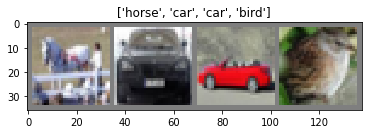

In [4]:
# TODO Task 1:  Run this cell and try to understand the output of each step

def imshow(inp, title=None):
    """Imshow for Tensor."""
    # 3d array the default axias is (0,1,2) (1,0,2) means 0 axis exchanges with 1 axis
    inp = inp.numpy().transpose((1, 2, 0))
    # recover image from the normalization operation
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    # clip(array_like, min, max) for every element if element < min (or > max), then element = min (=max)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
# batch sieze
# inputs, classes = next(iter(dataloaders['train']))
inputs, classes = iter(dataloaders['train']).next()

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Task 2: Basic Networks (20 points)
1. Create a Fully connected Network (FcNet) as follows in the Jupyter Notebook:
```
FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the FcNet for **3** epoches and record the training time and accuracy in your final report.

2. Create a Convolutional Network (ConvNet) as follows in the Jupyter Notebook:
```
ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the ConvNet for **3** epoches and record the training time and accuracy in your final report. 

*Use the default SGD optimizer ( lr=0.001, momentum=0.9) for training.

### Model training code (do not modify except for plotting the loss curve)

In [5]:
# Move to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [160]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()
    epoch_acc_list = []
    epoch_loss_list = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc_list.append(epoch_acc.item())
#             print(type(epoch_loss))
            epoch_loss_list.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    # return the accuracy of last epoch
    return model,epoch_acc_list,epoch_loss_list

### 1) FC Network

In [6]:
# 1) Define a Fully Connected Neural Network
# import torch.nn.functional as F  active functions package
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        # TODO Task 2:  Define the layers 
        self.input_layer = nn.Linear(3072, 1024)
        self.h_layer1 = nn.Linear(1024, 400)
        self.h_layer2 = nn.Linear(400, 84)
        self.output_layer = nn.Linear(84, 10)
    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        x1 = self.input_layer(x)
        x2 = self.h_layer1(x1)
        x3 = self.h_layer2(x2)
        x4 = self.output_layer(x3)
        x = x4
        return x

model_ft = FcNet()
model_ft = model_ft.to(device)
print(model_ft)

FcNet(
  (input_layer): Linear(in_features=3072, out_features=1024, bias=True)
  (h_layer1): Linear(in_features=1024, out_features=400, bias=True)
  (h_layer2): Linear(in_features=400, out_features=84, bias=True)
  (output_layer): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# my notes
# Use the nn package to define the model as a sequence of layers
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
# 5) Use Mean Squared Error (MSE) as the loss function
loss_fn = torch.nn.MSELoss(reduction='sum')
# 6) Compute and print loss.
loss = loss_fn(y_pred, y)
print(loss.item())
# 7) Zero the gradients before running the backward pass.
model.zero_grad()
# 8) Backward pass
loss.backward()

### 2) CNN

In [82]:
# 2) Define a Convolutional Neural Network
import torch.nn.functional as F
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # TODO Task 2:  Define the CNN layers 
        # 3: input channels 6: output chaneels 5: kernel_size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.maxpool2d = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
#           x = x.view(-1, 16 * 5 * 5)
        # TODO Task 2:  Define the forward pass
        x = self.maxpool2d(F.relu(self.conv1(x)))
        x = self.maxpool2d(F.relu(self.conv2(x)))
        # strech data into a 400-dimentional vector
#         print(x.shape)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

model_ft = ConvNet()
model_ft = model_ft.to(device)
print(model_ft)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=1)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 0/0
----------
train Loss: 1.7065 Acc: 0.3713

Training complete in 1m 10s


In [87]:
test_model(model_ft[0], load_path='saved_weight.pth')

test Acc: 0.4894
Testing complete in 0m 7s


## Task 3: Design Your Network I (20 points)
Define your own Convolutional Network (MyNet) starting from the configuration in Task 2.2. Add following modifications and train the Network for **25** epoches. Keep the best settings for each step (for each step, record the training accuracy of the last epoch and test accuracy in your report):

1. Increase the number of layers: Modify the number of convolutional layers in the network.
2. Increase the number of filters: Modify the number of filters in each convolutional layer of the network. 
3. Modify the filter sizes in each convolutional layer. Experiment with different filter sizes (3x3, 5x5 and 7x7).

## Task 4: Design Your Network II (20 points)
Keeping the best settings of Task 3, use **Dropout** in fully connected layers and Batch Normalization (choose a suitable batch size) in convolutional layers. Record the training accuracy of the last epoch and test accuracy in your report.

### Design Your Network

In [119]:
# Define a Convolutional Neural Network
class MyNet(nn.Module):
    def __init__(self, conv1_number_filters=8,conv2_number_filters=16,conv3_number_filters=22,cov1_filter_size=5,cov2_filter_size=5,cov3_filter_size=3):
        super(MyNet, self).__init__()
        # TODO Task 3 & 4: Design Your Network I & II 
        self.conv1 = nn.Conv2d(3, conv1_number_filters, cov1_filter_size)
        self.maxpool2d = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(conv1_number_filters, conv2_number_filters, cov2_filter_size)
        # add one more convolutional layer
        self.conv3 = nn.Conv2d(conv2_number_filters, conv3_number_filters, cov3_filter_size)
        self.dimention = (int((((32-cov1_filter_size+1)/2)-cov2_filter_size+1)/2-cov3_filter_size+1))**2*conv3_number_filters
#         print(int((((32-cov1_filter_size+1)/2)-cov2_filter_size+1)/2-cov3_filter_size+1))
#         print(self.dimention)
        self.fc1 = nn.Linear(self.dimention, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.conv3_number_filters = conv3_number_filters


    def forward(self, x):
        # TODO Task 3 & 4: Design Your Network I & II
        x = self.maxpool2d(F.relu(self.conv1(x)))
        x = self.maxpool2d(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        # strech data into a unknown dimentional vector
#         print(x.shape)
        x = x.view(-1, self.dimention)
#         print(x.shape)
#         print(x.shape) torch.Size([4, 32, 2, 2]) it should be [4, 32, 3, 3] cause the last convolutional layer doesn't need pool function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model_ft = MyNet()
print(model_ft)

MyNet(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 22, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=198, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [166]:
class MyNet2(MyNet):
    def __init__(self):
        # according to the observation, when the size of filters equals 3, the model has higher accuracy on classification
        super(MyNet2, self).__init__(cov1_filter_size=3,cov2_filter_size=3)
        # add dropout to fc 0.5 is the default value
        self.dropout = nn.Dropout(p=0.5)
        # the parameter means size
#         batch normalization won't change the size of input
        self.batchNorm2d = nn.BatchNorm2d(self.conv3_number_filters)
        self.featuremap1 = None
        self.featuremap2 = None
    
    # overried father's forward function
    def forward(self,x):
        # first cl feature map
        self.featuremap1 = F.relu(self.conv1(x))
        x = self.maxpool2d(F.relu(self.conv1(x)))
        x = self.maxpool2d(F.relu(self.conv2(x)))
        # batch normalize the last c layer
#         x = F.relu(self.batchNorm2d(self.conv3(x)))
        x = F.relu(self.batch_normalization(input_x=self.conv3(x),batch_size=2))
         # second cl feature map
        self.featuremap2 = x
        x = x.view(-1, self.dimention)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(self.dropout(x)))
        x = self.fc3(self.dropout(x))
        return x
    def batch_normalization(self,input_x,batch_size=4):
#         if batch_size==1:
#             output_list = []
#             for i in range(4):
#                 output = self.batchNorm2d(input_x[i])
#                 output_list[i]=output
#             return torch.cat((each_output for each_output in output_list), 0)
        if batch_size==2:
            output1 = self.batchNorm2d(input_x[:batch_size])
            output2 = self.batchNorm2d(input_x[batch_size:4])
            return torch.cat((output1, output2), 0)
        else:
            return self.batchNorm2d(input_x)
my_model_2 = MyNet2()
print(my_model_2)
test_accuracy_2 = test_model(my_model_2, 'saved_weightv2.pth')

MyNet2(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 22, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
  (batchNorm2d): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
test Acc: 0.6798
Testing complete in 0m 11s


In [149]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(my_model_2.parameters(), lr=0.001, momentum=0.9)
my_model_2,accuracy_2 = train_model(my_model_2, criterion, optimizer_ft, num_epochs=25,save_path='saved_weightv3.pth')
test_accuracy_2 = test_model(my_model_2, 'saved_weightv3.pth')

Epoch 0/24
----------
train Loss: 1.9412 Acc: 0.2805
Epoch 1/24
----------
train Loss: 1.7028 Acc: 0.3841
Epoch 2/24
----------
train Loss: 1.6103 Acc: 0.4231
Epoch 3/24
----------
train Loss: 1.5525 Acc: 0.4491
Epoch 4/24
----------
train Loss: 1.4977 Acc: 0.4732
Epoch 5/24
----------
train Loss: 1.4636 Acc: 0.4865
Epoch 6/24
----------
train Loss: 1.4322 Acc: 0.4979
Epoch 7/24
----------
train Loss: 1.4102 Acc: 0.5091
Epoch 8/24
----------
train Loss: 1.3870 Acc: 0.5186
Epoch 9/24
----------
train Loss: 1.3694 Acc: 0.5255
Epoch 10/24
----------
train Loss: 1.3508 Acc: 0.5341
Epoch 11/24
----------
train Loss: 1.3354 Acc: 0.5403
Epoch 12/24
----------
train Loss: 1.3218 Acc: 0.5449
Epoch 13/24
----------
train Loss: 1.3172 Acc: 0.5492
Epoch 14/24
----------
train Loss: 1.3004 Acc: 0.5537
Epoch 15/24
----------
train Loss: 1.2988 Acc: 0.5560
Epoch 16/24
----------
train Loss: 1.2922 Acc: 0.5591
Epoch 17/24
----------
train Loss: 1.2773 Acc: 0.5645
Epoch 18/24
----------
train Loss: 1.2

In [164]:
# # print(accuracy_2[24].item())
# # print(test_accuracy_2)
# accuracy_2

In [90]:
criterion = nn.CrossEntropyLoss()
# TODO Task 5: Optimizer

In [96]:
training_acc = {}
test_acc = {}
model_list = []
for size in [3,5,7]:
    my_model_ft = MyNet(cov1_filter_size=size,cov2_filter_size=size,cov3_filter_size=3)
    optimizer_ft = optim.SGD(my_model_ft.parameters(), lr=0.001, momentum=0.9)
    my_model_ft = my_model_ft.to(device)
    weight_path = 'saved_weight_{}.pth'.format(size)
    my_model_ft,accuracy = train_model(my_model_ft, criterion, optimizer_ft, num_epochs=25,save_path=weight_path)
    training_acc[size] = accuracy
    print(accuracy)
    # store model info
    model_list.append(my_model_ft)
    test_accuracy = test_model(my_model_ft, load_path=weight_path)
    test_acc[size]=test_accuracy
    print(test_accuracy)

Epoch 0/24
----------
train Loss: 1.9145 Acc: 0.2817
Epoch 1/24
----------
train Loss: 1.4468 Acc: 0.4770
Epoch 2/24
----------
train Loss: 1.2779 Acc: 0.5423
Epoch 3/24
----------
train Loss: 1.1729 Acc: 0.5840
Epoch 4/24
----------
train Loss: 1.0993 Acc: 0.6117
Epoch 5/24
----------
train Loss: 1.0428 Acc: 0.6330
Epoch 6/24
----------
train Loss: 1.0007 Acc: 0.6478
Epoch 7/24
----------
train Loss: 0.9631 Acc: 0.6636
Epoch 8/24
----------
train Loss: 0.9326 Acc: 0.6740
Epoch 9/24
----------
train Loss: 0.9076 Acc: 0.6843
Epoch 10/24
----------
train Loss: 0.8878 Acc: 0.6900
Epoch 11/24
----------
train Loss: 0.8751 Acc: 0.6954
Epoch 12/24
----------
train Loss: 0.8552 Acc: 0.7010
Epoch 13/24
----------
train Loss: 0.8419 Acc: 0.7038
Epoch 14/24
----------
train Loss: 0.8303 Acc: 0.7104
Epoch 15/24
----------
train Loss: 0.8233 Acc: 0.7128
Epoch 16/24
----------
train Loss: 0.8158 Acc: 0.7157
Epoch 17/24
----------
train Loss: 0.8054 Acc: 0.7184
Epoch 18/24
----------
train Loss: 0.7

In [107]:
## Train and evaluate
# using item() func to retrive scale value from tensor object
for size in [3,5,7]:
    print('Size of filters:{}, the last epoch accurcy is {}; the test accuracy is {}.'.format(size,(training_acc[size][24]).item(),test_acc[size].item()))
# print(test_acc)

Size of filters:3, the last epoch accurcy is 0.73442; the test accuracy is 0.6775.
Size of filters:5, the last epoch accurcy is 0.67398; the test accuracy is 0.6188.
Size of filters:7, the last epoch accurcy is 0.63612; the test accuracy is 0.6084.


In [108]:
print(model_list)

[MyNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 22, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
), MyNet(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 22, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=198, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
), MyNet(
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
  (maxp

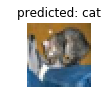

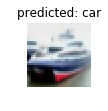

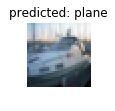

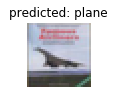

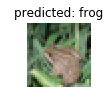

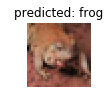

In [110]:
display_predictions(model_list[0])

## Task 5: The Optimizer (20 points)
Keeping the best settings of Task 4, use 3 different optimizers (SGD, ADAM and RMSProp) with 3 different learning rates (0.001, 0.01, 0.1) . Plot the loss curves (Training loss vs Training step) for each case.

In [158]:
# my notes
# 9) SGD optimizer
# optimizer1 = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# # 10) Adam optimizer
# optimizer2 = optim.Adam([var1, var2], lr=0.0001)
def get_optimizer(model, learning_rate,index):
    optimizer1 = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer2 = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer3 = torch.optim.RMSprop(model.parameters(),lr=learning_rate)
    optimizer_list = [optimizer1,optimizer2,optimizer3]
    return optimizer_list[index]

Epoch 0/24
----------
train Loss: 1.9284 Acc: 0.2858
Epoch 1/24
----------
train Loss: 1.6564 Acc: 0.4063
Epoch 2/24
----------
train Loss: 1.5502 Acc: 0.4484
Epoch 3/24
----------
train Loss: 1.4951 Acc: 0.4738
Epoch 4/24
----------
train Loss: 1.4507 Acc: 0.4929
Epoch 5/24
----------
train Loss: 1.4162 Acc: 0.5064
Epoch 6/24
----------
train Loss: 1.3844 Acc: 0.5200
Epoch 7/24
----------
train Loss: 1.3640 Acc: 0.5284
Epoch 8/24
----------
train Loss: 1.3381 Acc: 0.5387
Epoch 9/24
----------
train Loss: 1.3263 Acc: 0.5419
Epoch 10/24
----------
train Loss: 1.3103 Acc: 0.5490
Epoch 11/24
----------
train Loss: 1.2941 Acc: 0.5521
Epoch 12/24
----------
train Loss: 1.2831 Acc: 0.5596
Epoch 13/24
----------
train Loss: 1.2746 Acc: 0.5639
Epoch 14/24
----------
train Loss: 1.2643 Acc: 0.5705
Epoch 15/24
----------
train Loss: 1.2475 Acc: 0.5750
Epoch 16/24
----------
train Loss: 1.2495 Acc: 0.5739
Epoch 17/24
----------
train Loss: 1.2369 Acc: 0.5830
Epoch 18/24
----------
train Loss: 1.2

Epoch 0/24
----------
train Loss: 1.8526 Acc: 0.3245
Epoch 1/24
----------
train Loss: 1.6859 Acc: 0.4051
Epoch 2/24
----------
train Loss: 1.6330 Acc: 0.4269
Epoch 3/24
----------
train Loss: 1.6139 Acc: 0.4391
Epoch 4/24
----------
train Loss: 1.6060 Acc: 0.4432
Epoch 5/24
----------
train Loss: 1.6199 Acc: 0.4407
Epoch 6/24
----------
train Loss: 1.6283 Acc: 0.4374
Epoch 7/24
----------
train Loss: 1.6217 Acc: 0.4415
Epoch 8/24
----------
train Loss: 1.6506 Acc: 0.4311
Epoch 9/24
----------
train Loss: 1.6786 Acc: 0.4128
Epoch 10/24
----------
train Loss: 1.7009 Acc: 0.4048
Epoch 11/24
----------
train Loss: 1.7536 Acc: 0.3811
Epoch 12/24
----------
train Loss: 1.7434 Acc: 0.3792
Epoch 13/24
----------
train Loss: 1.7530 Acc: 0.3786
Epoch 14/24
----------
train Loss: 1.7841 Acc: 0.3659
Epoch 15/24
----------
train Loss: 1.7683 Acc: 0.3650
Epoch 16/24
----------
train Loss: 1.7683 Acc: 0.3692
Epoch 17/24
----------
train Loss: 1.7641 Acc: 0.3694
Epoch 18/24
----------
train Loss: 1.7

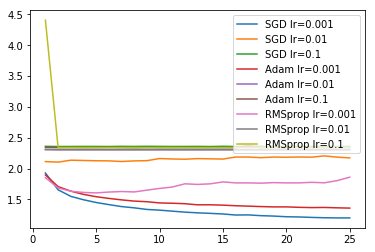

In [161]:
criterion = nn.CrossEntropyLoss()
lr_list = (0.001, 0.01, 0.1)
optm_names_list = ('SGD','Adam','RMSprop')
a_axis = np.arange(1,26)
fig, ax = plt.subplots()
saved_path = 'saved_weight_optimizer{}_{}.pth'
for i in range(3):
    for j in range(3):
        my_model_3 = MyNet2()
        optimizer_ft = get_optimizer(my_model_3, lr_list[j],i)
        # train
        my_model_3,accuracy_3,loss_3 = train_model(my_model_3, criterion, optimizer_ft, num_epochs=25,save_path=saved_path.format(i,j))
        # test
#         test_accuracy_3 = test_model(my_model_3, saved_path.format(i,j))
        # plot
        ax.plot(a_axis,loss_3, label=optm_names_list[i]+' '+'lr={}'.format(lr_list[j]))
        ax.legend()
plt.show()

### Testing the Accuracy

In [139]:
def test_model(model, load_path='saved_weight.pth'):    
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()

    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return epoch_acc.item()

In [ ]:
test_model(model_ft)

### Display model predictions

In [109]:
## Display model predictions
## Generic function to display predictions for a few images

def display_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
display_predictions(model_ft)

## Task 6: Visualization (10 points)
Visualize feature maps of the first and the last convolutional layer of your final network using **cifar_example.jpg** as input image. Show the visualization in the report.

#### First layer activations
<img src="https://i.imgur.com/kGB9AuP.png" width="400" align="left">

#### Last layer activations

<img src="https://i.imgur.com/qelH05X.png" width="400" align="left">

## Save the Feature Maps

In [ ]:
# TODO Task 6: Visualization

In [167]:
def transfer_single_img_to_tensor(img_path):
    im = Image.open(img_path)
    img = np.asarray(im)/255
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    inp = (img - mean) / std
    inp = np.asarray(inp, dtype=np.float32)
    inp = inp.transpose((2, 0, 1))
    inp = np.expand_dims(inp, axis=0)
    inp = torch.from_numpy(inp, )
    inputs = inp.to(device)
    return inputs

In [168]:
inputs = transfer_single_img_to_tensor('example_imgs/cifar_example.jpg')
my_model_2.eval()
with torch.no_grad():
    my_model_2(inputs)

In [169]:
# Model_ft.featuremap1 and model_ft.featuremap2 should be the first and the last feature maps.
# Add model_ft.featuremap1 and model_ft.featuremap2 at suitable places in your network

feature_ouput1 = my_model_2.featuremap1.transpose(1,0).cpu()
feature_ouput2 = my_model_2.featuremap2.transpose(1,0).cpu()

In [170]:
def feature_imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

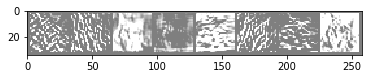

In [171]:
out = torchvision.utils.make_grid(feature_ouput1)
feature_imshow(out)

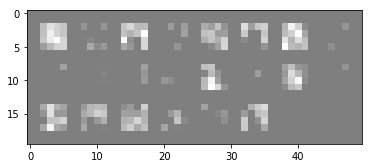

In [172]:
out = torchvision.utils.make_grid(feature_ouput2)
feature_imshow(out)